# RV-Only Fit Example: TOI-2431 b

## Importing ExoMUSE and required libraries

In [33]:
#We first use %matplotlib inline to display the plots in the notebook.
%matplotlib inline

In [34]:
#We then import the required libraries.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

import corner
import radvel

import os
import sys
import astropy.time

In [35]:
#We then import the ExoMUSE codes.
#Now we import the GaiaRV source codes.
sys.path.insert(0, '../../ExoMUSE/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import ExoMUSE_fit.py, ExoMUSE_utils.py, and ExoMUSE_gaiasource.py as standards.
import ExoMUSE_fit
import ExoMUSE_utils
import ExoMUSE_gaiasource

reload(ExoMUSE_fit)

ExoMUSE_fit, ExoMUSE_utils, ExoMUSE_gaiasource

list.remove(x): x not in list


(<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_fit.py'>,
 <module 'ExoMUSE_utils' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_utils.py'>,
 <module 'ExoMUSE_gaiasource' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_gaiasource.py'>)

In [36]:
#We also import rcParams to keep our plots consistent throughout various notebooks.
from matplotlib import rcParams

#We change the formating of the plots.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

## Data Input

In [37]:
#We import the datasets.
#Since this is an RV-Only Fit we import:
    #RV Data

#We read the RV dataset file.
df_raw = pd.read_csv("../../data/rvdata/TOI-2431_RV_data_NEID.csv")

#Optional: We add the instrument name to the dataframe.
df_raw["tel"] = ["NEID" for i in range(len(df_raw))]

#We take "bjd", "rv" and "e_rv" columns from the dataset. (and the "tel" we have added)
df = df_raw[["bjd", "rv", "e_rv", "tel"]]

#We then define these columns as "time", "mnvel", "errvel". (and "tel")
df.columns = ["time", "mnvel", "errvel", "tel"]

df


,time,mnvel,errvel,tel
0,2.460662e+06,-8.980639,2.618923,NEID
1,2.460662e+06,-21.921024,3.141299,NEID
2,2.460664e+06,-1.938046,2.359089,NEID
3,2.460665e+06,6.412131,1.850221,NEID
4,2.460666e+06,9.844131,1.807651,NEID
5,2.460681e+06,-12.130043,4.233394,NEID
6,2.460681e+06,6.774739,2.815522,NEID
7,2.460686e+06,4.610357,5.800396,NEID
8,2.460726e+06,-1.362416,2.957234,NEID
9,2.460726e+06,-6.294036,2.703145,NEID


## Setting up the Priors 

In [38]:
#We then import the Prior file for the RV-Only Fit.
f = "../../data/rvpriors/TOI2431_PriorsRV.txt"

reload(ExoMUSE_fit)

<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_fit.py'>

## Setting up the Likelihood

In [39]:
#We then pull time, RV and RV errors from the dataset.
#Note that you could also directly use df_raw.
t = df["time"].values
rv = df["mnvel"].values
e_rv = df["errvel"].values

#We then use "LPFunctionRVOnly" for the RV-Only Fit.
    #"LPFunction" => Log-Likelihood Function
    #"RV Only" => RV-Only Fit

#We setup our Log-Likelihood Function by using the dataset and the prior file.
#Note that this function prints out the Priors.
L = ExoMUSE_fit.LPFunctionRVOnly(t, rv, e_rv, file_priors = f)

Reading in priorfile from ../../data/rvpriors/TOI2431_PriorsRV.txt
   prior          arg1          arg2        label  description priortype  \
0     NP  2.241950e-01  4.000000e-07         P_p1         P_p1     model   
1     NP  2.460259e+06  4.664000e-04        tp_p1        tp_p1     model   
2     UP  0.000000e+00  1.000000e+00         b_p1         b_p1     model   
3     UP  0.000000e+00  1.000000e+00         p_p1         p_p1     model   
4     FP  0.000000e+00  0.000000e+00       ecc_p1       ecc_p1     model   
5     FP  9.000000e+01  9.000000e+01     omega_p1     omega_p1     model   
6     NP  3.230000e+03  1.800000e+02          rho          rho     model   
7     UP  0.000000e+00  1.000000e+03         K_p1         K_p1     model   
8     UP -5.000000e+02  5.000000e+02        gamma        gamma     model   
9     FP  0.000000e+00  0.000000e+00     sigma_rv     sigma_rv     model   
10    FP  0.000000e+00  0.000000e+00     gammadot     gammadot     model   
11    FP  0.000000e+0

In [40]:
#We then define a fitting object by using the Log-Likelihood as follows.
TF = ExoMUSE_fit.ExoMUSEfitRVOnly(L)

## Setting up the MCMC run

In [41]:
#For the MCMC, we use pyDE and emcee.
#We use pyDE to find the initial points for the chains.
#We then use emcee.EnsembleSampler to run the MCMC chains.
#This is all done by .minimize_pyDE() function from ExoMUSE_Fit.
    #de_iter => Differential Evolutions iterations, used for the distribution of walkers.
        #To distribute better, we increase de_iter.
        #However, this would increase the initial optimization time.
    #mc_iter => MCMC iterations, used for the number of steps in the chains.
        #We can evaluate the chains using GR Statistic and/or Autocorrelation time.
        #Depending on the evaluations, we can increase the mc_iter.
        #However, this will of course increase the time of the MCMC run.

TF.minimize_PyDE(de_iter=400,mc_iter=6000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
  labels       centers         lower         upper            pv   center_dist
0   P_p1  2.241950e-01  2.241930e-01  2.241970e-01  2.241951e-01 -5.349416e-08
1  tp_p1  2.460259e+06  2.460259e+06  2.460259e+06  2.460259e+06 -3.295252e-05
2   b_p1  5.000000e-01  0.000000e+00  1.000000e+00  4.122122e-01  8.778779e-02
3   p_p1  5.000000e-01  0.000000e+00  1.000000e+00  7.347060e-01 -2.347060e-01
4    rho  3.230000e+03  2.330000e+03  4.130000e+03  3.234678e+03 -4.677681e+00
5   K_p1  5.000000e+02  0.000000e+00  1.000000e+03  1.669711e+00  4.983303e+02
6  gamma  0.000000e+00 -5.000000e+02  5.000000e+02 -5.049500e-01  5.049500e-01
LogPost value: -90.9167172639033
LnL value: -91.54192630835333
Log priors 0.6252090444500293
Running MCMC
MCMC iterations= 6000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62

## Flattening the Chains

In [42]:
#We can define the burn-in period to be the first 1000 steps.
#This means that we will discard the first 1000 samples from each chain.
burnin_index = 1000

#We then discard the first 1000 samples from all of the chains as follows.
    #First part: We take all the chains.
    #Second part: We discard the first 1000 samples per chain.
    #Third part: We take all the parameters that were in the MCMC run.
chains_after_burnin = TF.sampler.chain[ : , burnin_index : , : ]

#We then have to reshape the chains to obtain the flatchain as follows.
    #TF.lpf => ExoMUSE_fit.LPFunctionRVOnly
    #.ps_vary => The Prior Set of the parameters that vary (from priors.py)
    #.priors => The priors of the varying parameters.
flatchain = chains_after_burnin.reshape((-1, len(TF.lpf.ps_vary.priors)))

In [43]:
#To store the posteriors from the flatchain, we can define a pandas DataFrame.
    #This time TF.lpf.ps_vary.labels takes the name of the varying parameters.
df_post = pd.DataFrame(flatchain, columns = TF.lpf.ps_vary.labels)

df_post

,P_p1,tp_p1,b_p1,p_p1,rho,K_p1,gamma
0,0.224195,2.460259e+06,0.467502,0.409102,3122.536603,0.536949,0.663229
1,0.224195,2.460259e+06,0.467502,0.409102,3122.536603,0.536949,0.663229
2,0.224195,2.460259e+06,0.467502,0.409102,3122.536603,0.536949,0.663229
3,0.224195,2.460259e+06,0.467502,0.409102,3122.536603,0.536949,0.663229
4,0.224195,2.460259e+06,0.467502,0.409102,3122.536603,0.536949,0.663229
...,...,...,...,...,...,...,...
499995,0.224195,2.460259e+06,0.841335,0.840358,3324.246364,2.212637,-0.254261
499996,0.224195,2.460259e+06,0.841335,0.840358,3324.246364,2.212637,-0.254261
499997,0.224195,2.460259e+06,0.841335,0.840358,3324.246364,2.212637,-0.254261
499998,0.224195,2.460259e+06,0.841335,0.840358,3324.246364,2.212637,-0.254261


## Assessing the Chain

In [44]:
#To check and assess the chains, we can use mcmc_help.
import mcmc_help

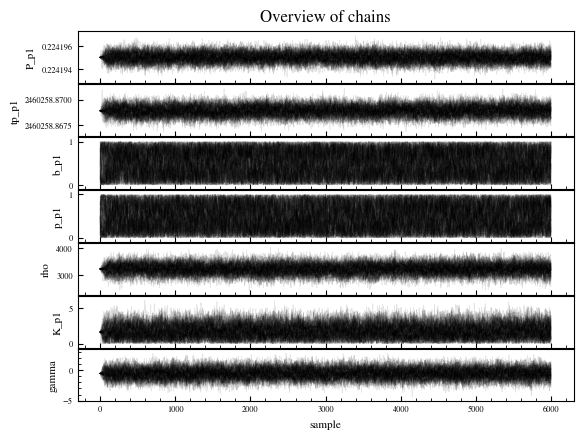

In [45]:
#We use the plot_chains function from the mcmc_help module to plot the chains.
#Note that TF.sampler is equivalent to an emcee.EnsembleSampler object.
mcmc_help.plot_chains(TF.sampler.chain, labels = TF.lpf.ps_vary.labels)

plt.show();

In [46]:
#We can also check the Gelman-Rubin (GR) Statistic to evaluate the chains of each parameter.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR Statistics:")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
print(50 * "-")

GR Statistics:
--------------------------------------------------
[1.01316132 1.01447484 1.01235425 1.01285354 1.00934385 1.01013222
 1.01420104]
--------------------------------------------------


In [47]:
#We can also check the autocorrelation time of the chains.
#If the chain isn't long enough, we would get the following error:
    #The chain is shorter than 50 times the integrated autocorrelation time for x parameter(s).
    #Use this estimate with caution and run a longer chain: N/50 = 40
print(50 * "-")
print("Autocorrelation Time")
print(50 * "-")
tau = TF.sampler.get_autocorr_time()
print(tau)
print(50 * "-")

--------------------------------------------------
Autocorrelation Time
--------------------------------------------------
[104.12686131  98.6509948  116.32173274 106.39696876  91.28423793
 102.0317582   98.47844454]
--------------------------------------------------


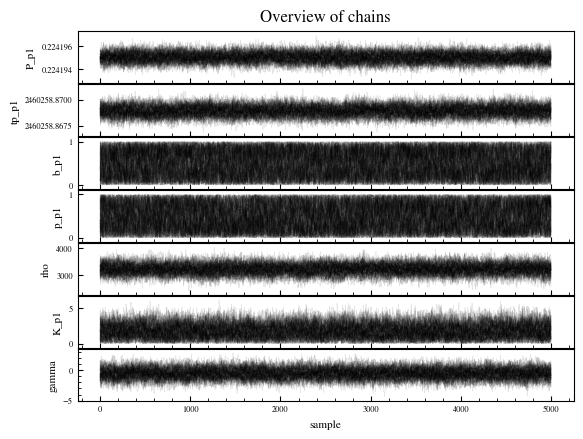

In [48]:
#We can also check how the flatchains look by plotting the flatchains.
mcmc_help.plot_chains(chains_after_burnin, labels = TF.lpf.ps_vary.labels)
plt.show();

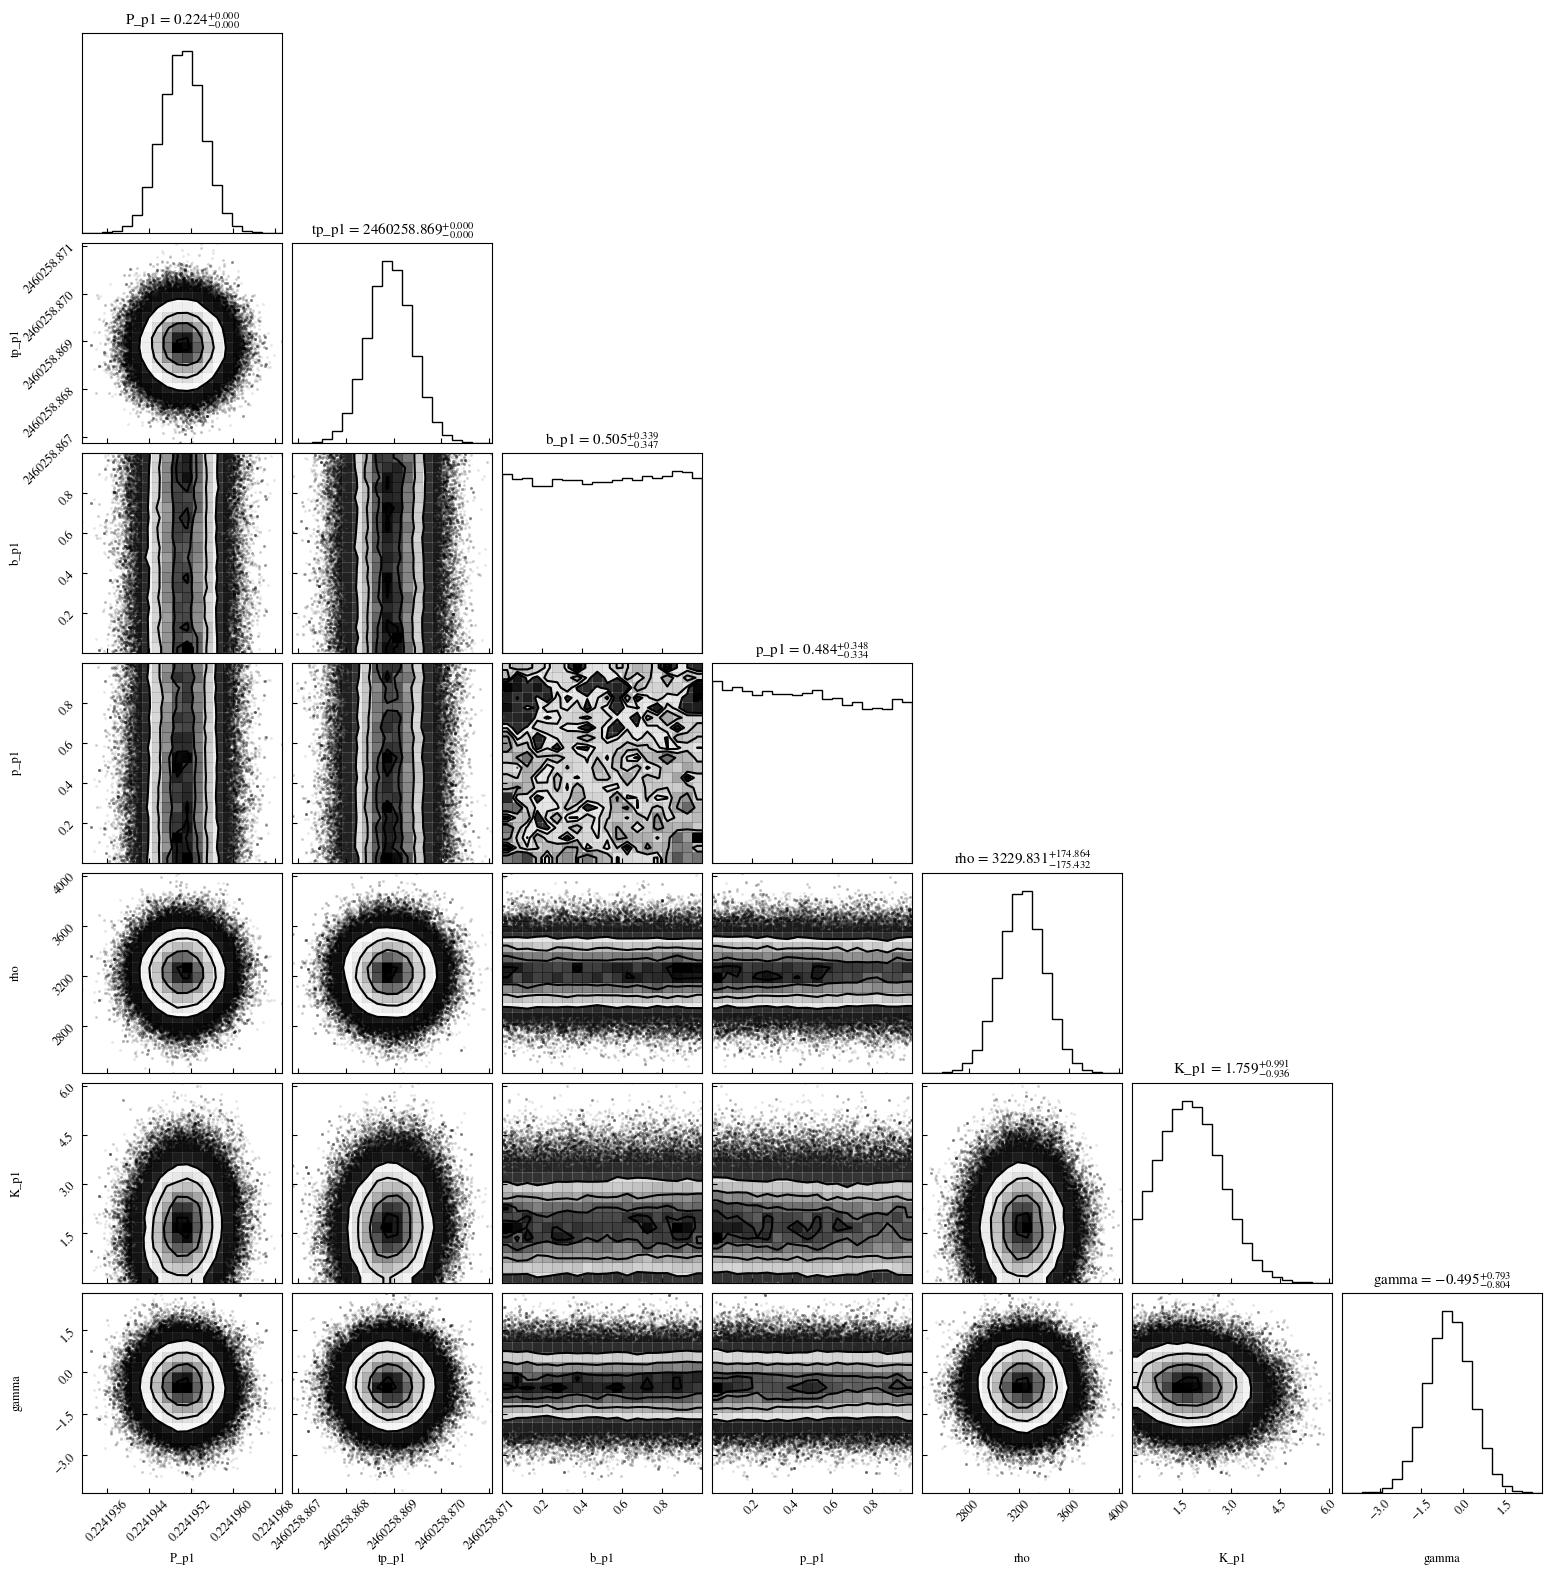

In [49]:
#We can also plot the corner plot to see the correlations and the posterior distributions
#of each parameter that was in the MCMC run.
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

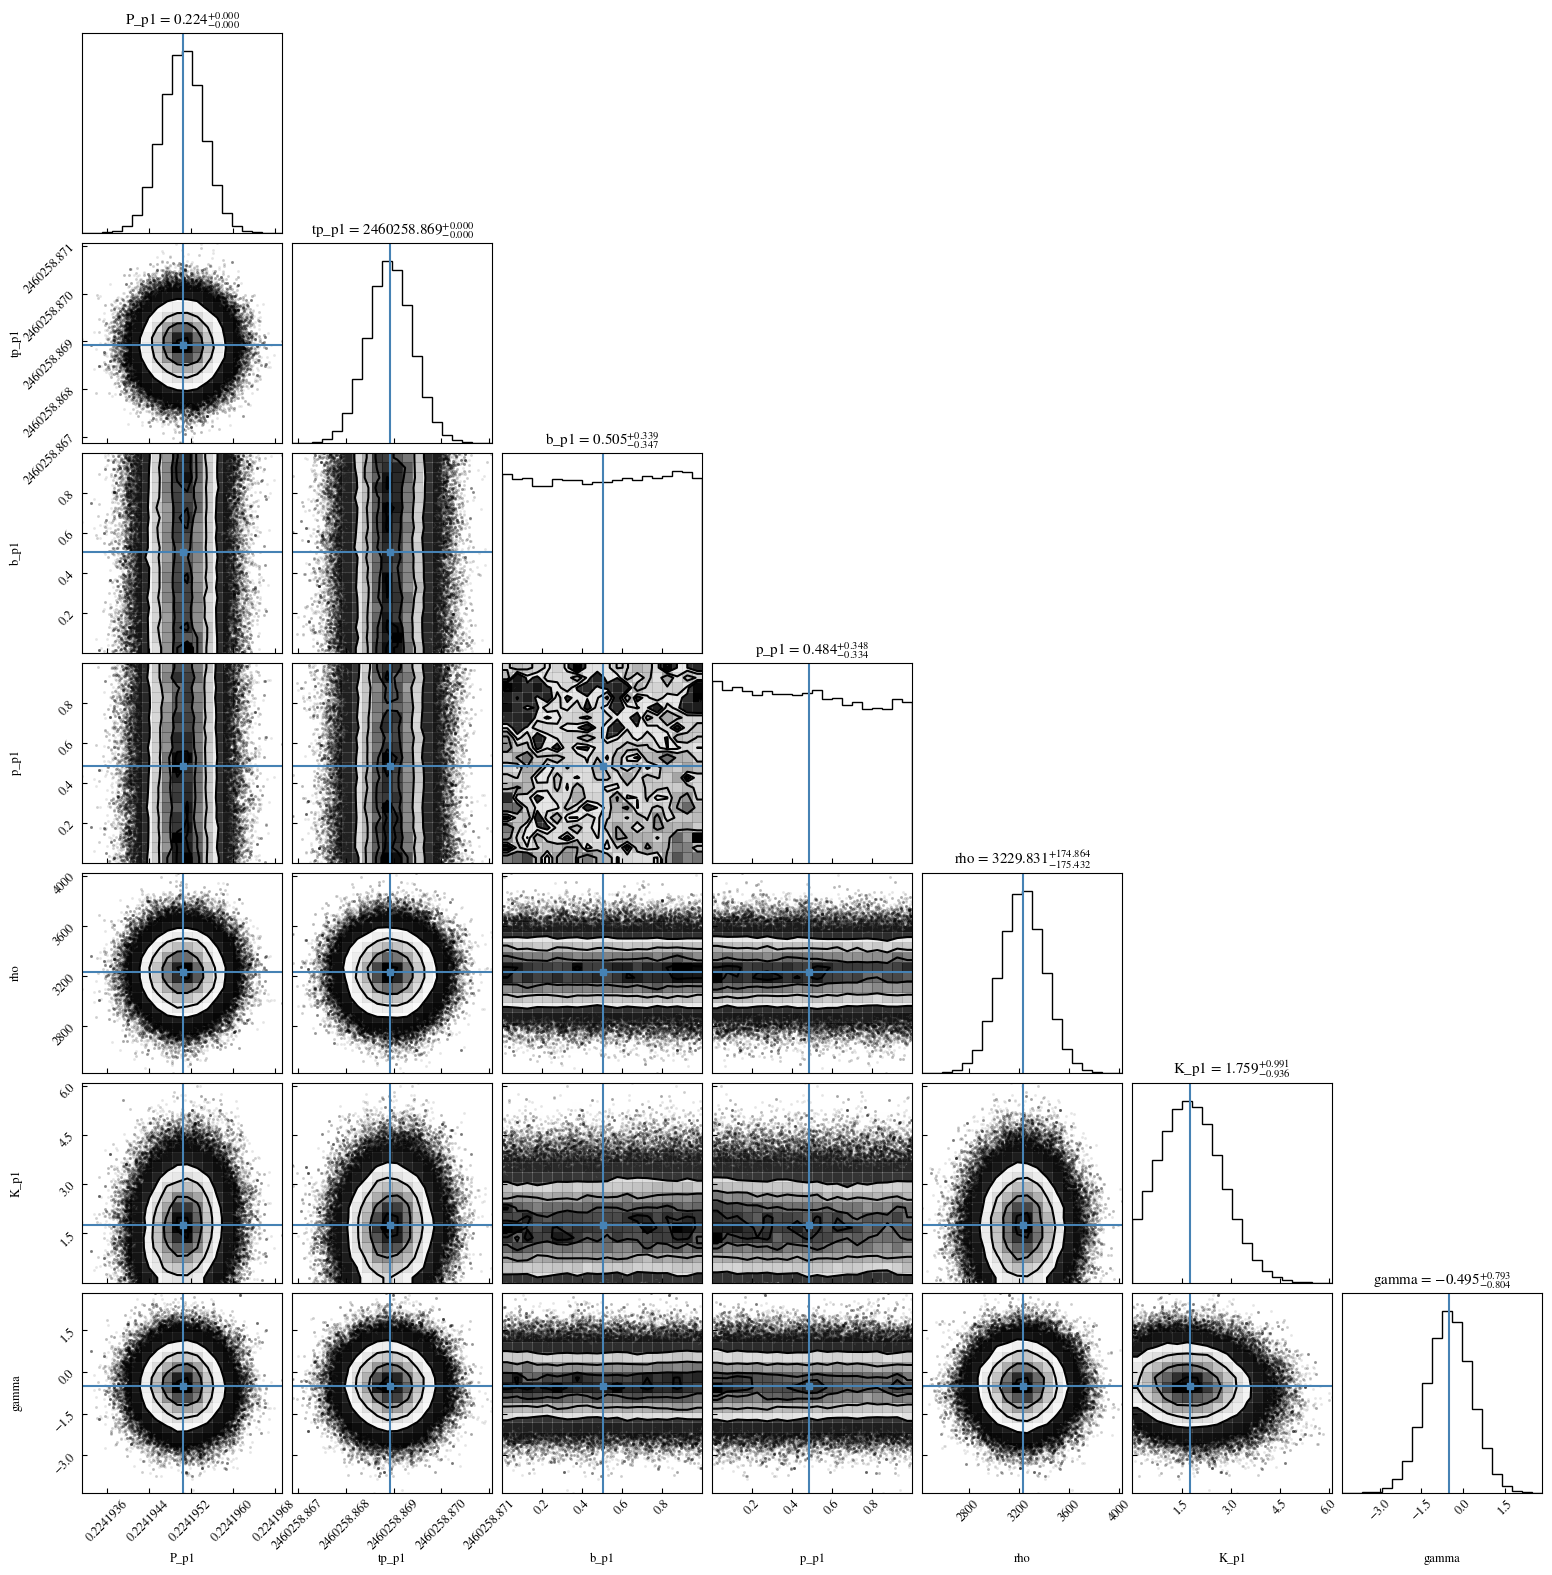

In [50]:
#We can also plot the corner plot with 50th percentile, i.e., the median to see whether
#the posterior distributions are sampled correctly or not.
#We first find the median of each parameter.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We then plot the corner plot and the median.
corner.corner(df_post.iloc[:, :].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

## Working with the Posteriors

In [51]:
#We can obtain the median and uncertainties of each parameter by using the
#.get_mean_values_mcmc_posteriors() function from ExoMUSE_fit.LPFunctionRVOnly.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)

df_medvals

,medvals,minus,plus,values,Labels,Description
0,2.241950e-01,3.997422e-07,3.930662e-07,$0.22419505_{-0.0000004}^{+0.0000004}$,P_p1,P_p1
0,2.460259e+06,4.640440e-04,4.635379e-04,$2460258.86893_{-0.00046}^{+0.00046}$,tp_p1,tp_p1
0,5.052333e-01,3.467936e-01,3.394509e-01,$0.51_{-0.35}^{+0.34}$,b_p1,b_p1
0,4.841526e-01,3.336033e-01,3.480655e-01,$0.48_{-0.33}^{+0.35}$,p_p1,p_p1
0,3.229831e+03,1.754318e+02,1.748644e+02,$3230.0_{-180.0}^{+170.0}$,rho,rho
0,1.758665e+00,9.355901e-01,9.911764e-01,$1.76_{-0.94}^{+0.99}$,K_p1,K_p1
0,-4.949801e-01,8.037564e-01,7.934006e-01,$-0.49_{-0.80}^{+0.79}$,gamma,gamma


In [52]:
df_medvals[["Labels", "values"]]

,Labels,values
0,P_p1,$0.22419505_{-0.0000004}^{+0.0000004}$
0,tp_p1,$2460258.86893_{-0.00046}^{+0.00046}$
0,b_p1,$0.51_{-0.35}^{+0.34}$
0,p_p1,$0.48_{-0.33}^{+0.35}$
0,rho,$3230.0_{-180.0}^{+170.0}$
0,K_p1,$1.76_{-0.94}^{+0.99}$
0,gamma,$-0.49_{-0.80}^{+0.79}$


In [53]:
#We can also calculate other parameters, such as the Mass of the Planet.
#To do this we can use ExoMUSE_utils function msini_from_rvs.
#The function is defined as msini_from_rvs(K, M_star, P, e, i):
    #K => Semi-Amplitude in m/s
    #M_star => Stellar Mass in Solar Masses.
    #P => Period in days.
    #e => Eccentricity.
    #i => Inclination in degrees.
#Note that ExoMUSE_utils.msini_from_rvs() function returns the mass in Jupiter Masses.

#In our case, since we do not have the stellar mass we can get it from external sources.
#Assuming a median of 0.64 and an uncertainty of 0.085, we can sample from this "normal"
#distribution to sample the mass of the planet accurately.
#We also assume e = 0 and i = 90 in our fit.
df_post["mp"] = ExoMUSE_utils.msini_from_rvs(df_post["K_p1"].values,
                                             np.random.normal(0.6400000,0.0846982,flatchain.shape[0]),
                                             df_post["P_p1"].values,
                                             e = 0,
                                             i = 90)

#We can then use get_vals from ExoMUSE_utils to get the median and uncertainties of the mass.
#Since the returned masses are in Jupiter masses and 1 M_jupiter = 317.828 M_earth, we can
#multiply the returned mass chain by 317.828 to convert it to Earth masses.
mp = ExoMUSE_utils.get_vals(df_post["mp"].values * 317.828, print_result = True, param_name = "Mplanet")

#We can also print the mass of the planet by using the outputs from get_vals:
    #First output: Median value
    #Second output: Lower uncertainty
    #Third output: Upper uncertainty
print(f"Mass of the Planet: {mp[0]}, +{mp[2]} -{mp[1]} M_Earth")

Mplanet: 1.229311 +0.716281 -0.659335
Mass of the Planet: 1.2293108755460542, +0.7162812317751386 -0.6593351042398864 M_Earth


## Plotting the Data and the Best-Fit Model

In [54]:
#We first define the Title and the amount of times we will sample the model.
TITLE = "TOI-2431 RV-Only Fit"
NUM_SAMPLES = 5000

### Plotting the Data and the Best-Fit Model over Time

In [55]:
#We can first plot the data and the best-fit model over time.
    #Optional: If there we want to convert Julian Dates into Datetimes, i.e. DD-MM-YYYY format,
    #we can use ExoMUSE_utils.jd2datetime(times) function, where times is in Julian Dates.

#For this, we first get the times from our dataset.
times_data = TF.lpf.data["x"]

times_data

array([2460661.69434182, 2460661.83431809, 2460663.81846735,
       2460664.63461503, 2460665.58387257, 2460680.64477062,
       2460680.74655183, 2460685.70225794, 2460725.61728925,
       2460725.62103128, 2460725.67232209, 2460725.6758779 ])

In [56]:
#We first get the medians of the parameters by using the flatchain.
#This again can be obtained by checking the 50th percentile of the flatchains.
pv_50 = np.percentile(flatchain, [50], axis=0)[0]

#We then define the amount of times where we will sample the Best-Fit Model.
times_model = np.linspace(times_data.min(), times_data.max(), NUM_SAMPLES)

#We then compute the best-fit model by using the median values and defined times.
rv_model = TF.lpf.compute_total_model(pv_50, times_model)

#We also compute the radial velocity data from the model at the observation times.
rv_data_from_model = TF.lpf.compute_total_model(pv_50, times_data)

#From here, we can calculate the residuals, i.e., DATA - MODEL
residuals = TF.lpf.data["y"] - rv_data_from_model

In [57]:
#We can also plot the uncertainty intervals of our model.
#For this, we can define the following loop that does:
    #1-) Sample a random vector of parameters from the flatchain. E.g. 200th chain
    #2-) Compute the RV curve using the sampled parameter set/vector.
    #3-) Add this RV curve model to a list.
    #4-) Sample from this list to get the uncertainty intervals.

#For this we first define a list to store all of the RV models.
rv_models_for_uncertainty = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    rv_models_for_uncertainty.append(model)

#We then convert this list to an array.
rv_models_for_uncertainty = np.array(rv_models_for_uncertainty)

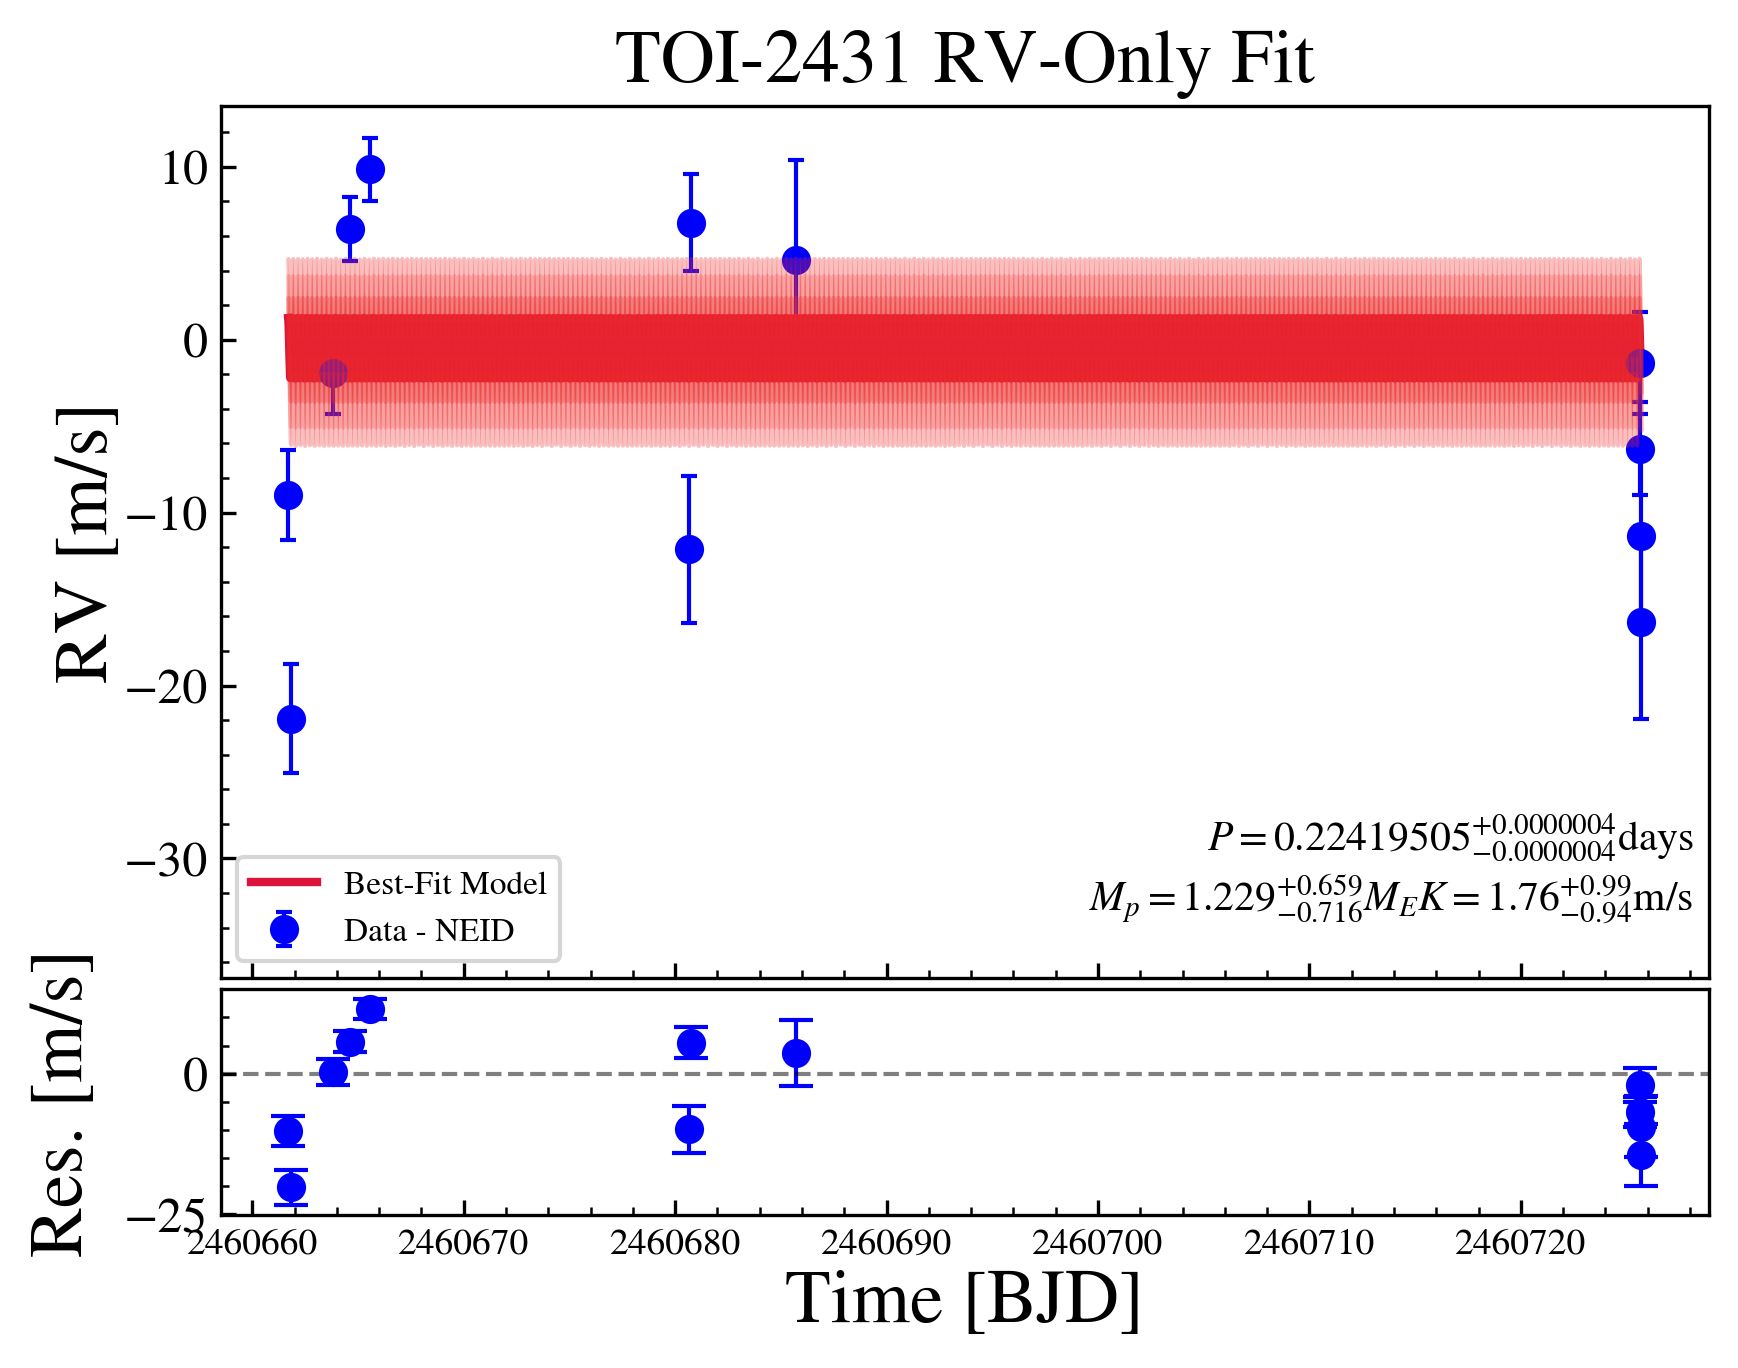

In [58]:
#We then plot our data.
#For this we define 2 rows with one of them for the RV and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"
label_params += "$M_p=${}$M_E$".format(f"${mp[0]:.3f}_{{-{mp[2]:.3f}}}^{{+{mp[1]:.3f}}}$")
label_params += "$K=${}".format(df_medvals[df_medvals.Labels=="K_p1"]["values"].values[0])+"m/s\n"

#We can also add the model of RV uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv"].values[0]

#In this fit, it was fixed to zero.
uncertainty_sigma = 0
inflated_rv_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(TF.lpf.data["x"], TF.lpf.data["y"], yerr = inflated_rv_err,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - NEID', zorder = -10)

#We also plot our best-fit model.
ax.plot(times_model, rv_model, color="crimson", label = "Best-Fit Model", lw=2., zorder=-10)

#We then plot the residuals.
bx.errorbar(TF.lpf.data["x"], residuals, yerr = inflated_rv_err,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -10)

#Optional: We add the parameter values onto the bottom-right of the RV graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using rv_models_for_uncertainty.
#1 Sigma Interval
ax.fill_between(times_model, 
                np.percentile(rv_models_for_uncertainty, 16, axis=0),
                np.percentile(rv_models_for_uncertainty, 84, axis=0),
                color='#EE2C2C', alpha=0.3)
#2 Sigma Interval
ax.fill_between(times_model, 
                np.percentile(rv_models_for_uncertainty, 2, axis=0),
                np.percentile(rv_models_for_uncertainty, 98, axis=0),
                color='#EE2C2C', alpha=0.2)
#3 Sigma Interval
ax.fill_between(times_model, 
                np.percentile(rv_models_for_uncertainty, 0.15, axis=0),
                np.percentile(rv_models_for_uncertainty, 99.85, axis=0),
                color='#EE2C2C', alpha=0.3)

#We then set the labels and titles for the plot.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)
bx.set_xlabel('Time [BJD]',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-10, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

### Plotting the Data and the Best-Fit Model over Phase

In [59]:
#To plot the Data and the Best-Fit model over Phase, we first need to get the Period and T0
#from the flatchains.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "tp_p1"].values[0]

#We can then use ExoMUSE_utils.time_to_phase(times, P, T0) function to convert the times
#to phase.
phase_data = ExoMUSE_utils.time_to_phase(times_data, P, T_0)

#We then convert the model times to phase too.
phase_model = ExoMUSE_utils.time_to_phase(times_model, P, T_0)

#We then have to sort the data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
rv_model_sorted = rv_model[sorted_indices]

In [60]:
#We can again the uncertainty intervals of our model.
#It is the same structure as before.

#For this we first define a list to store all of the RV models.
rv_models_for_uncertainty_phase = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    model_sorted = model[sorted_indices]
    rv_models_for_uncertainty_phase.append(model_sorted)

#We then convert this list to an array.
rv_models_for_uncertainty_phase = np.array(rv_models_for_uncertainty_phase)

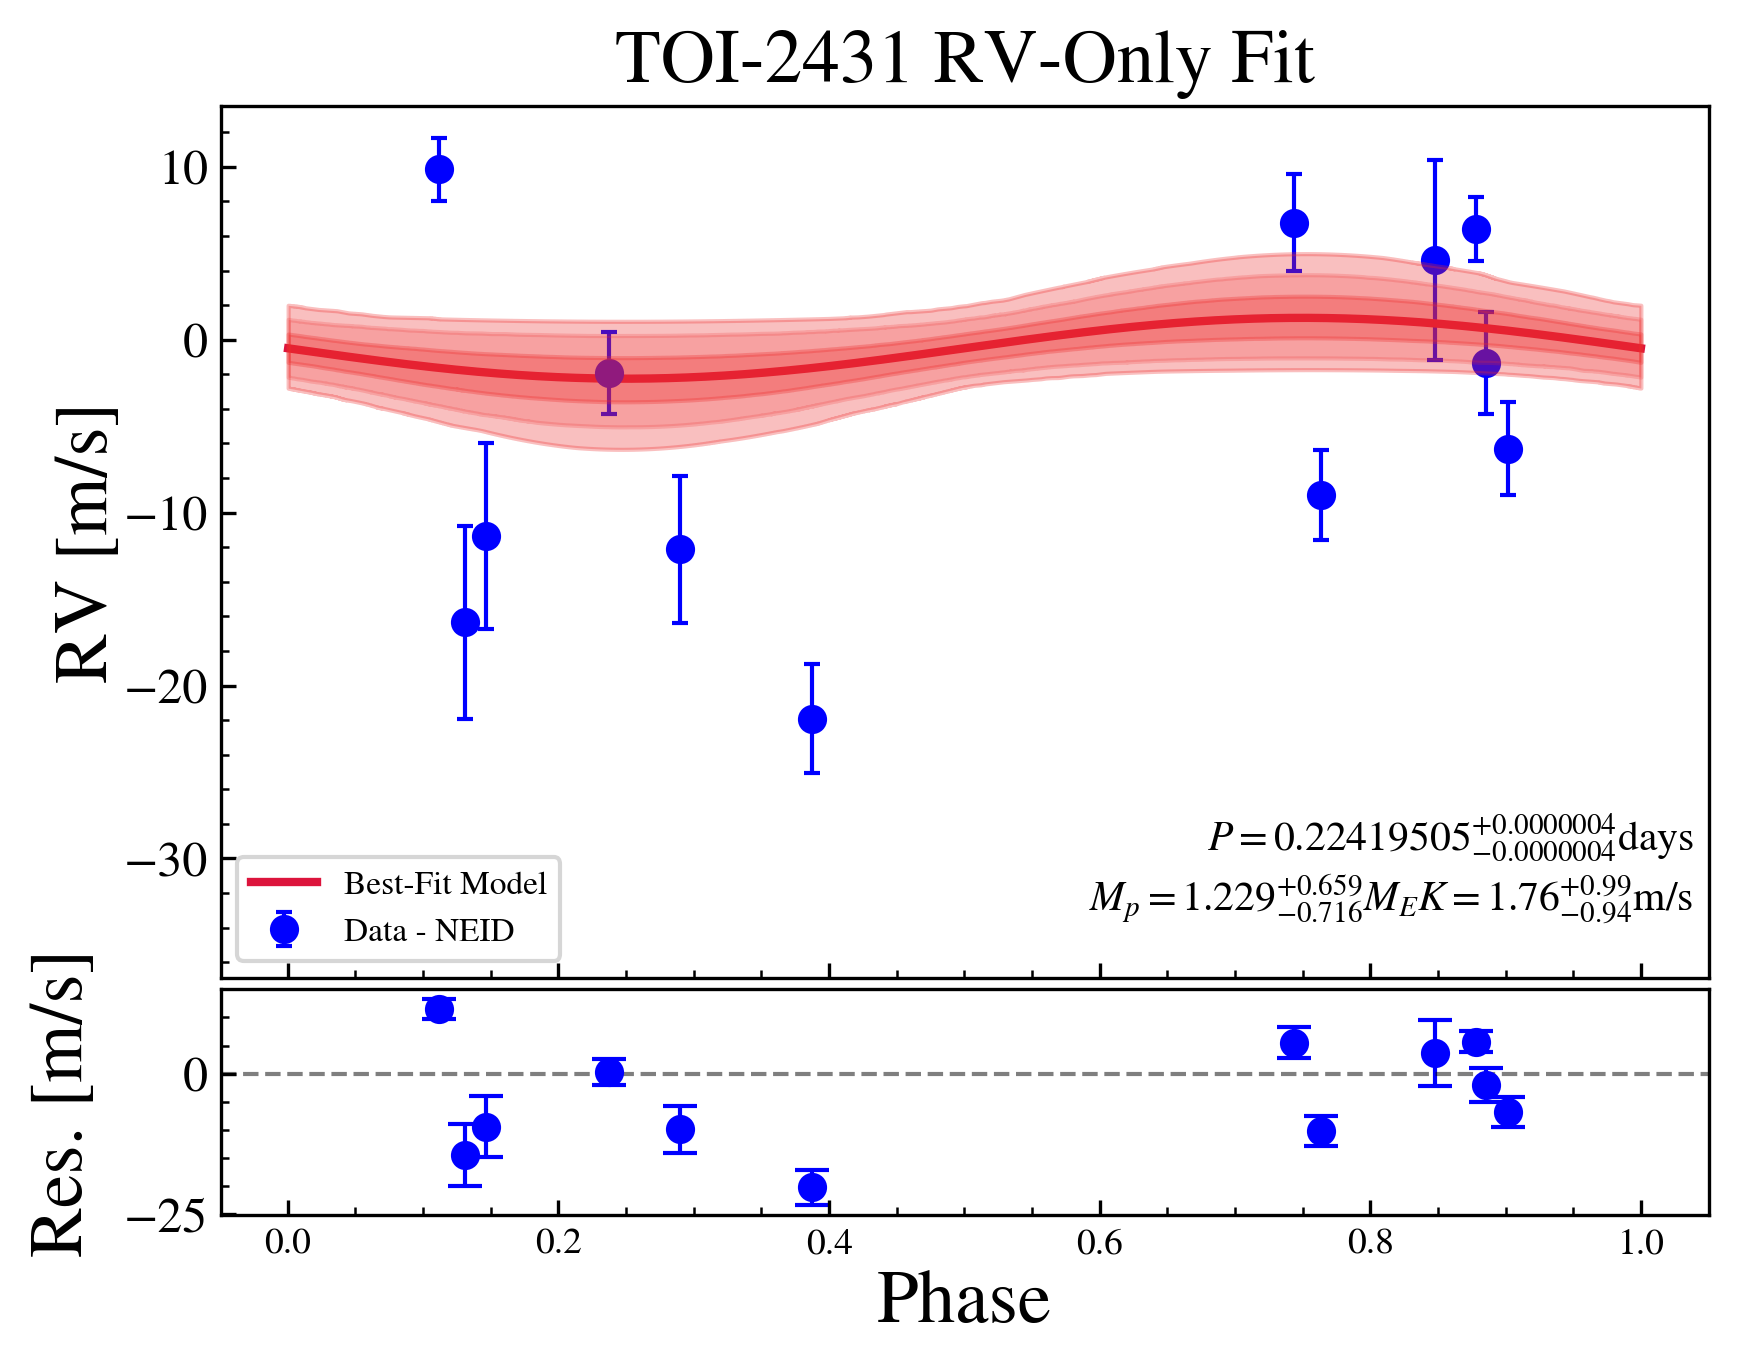

In [61]:
#We can then again plot the data as follows.
#We then plot our data.
#For this we define 2 rows with one of them for the RV and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"
label_params += "$M_p=${}$M_E$".format(f"${mp[0]:.3f}_{{-{mp[2]:.3f}}}^{{+{mp[1]:.3f}}}$")
label_params += "$K=${}".format(df_medvals[df_medvals.Labels=="K_p1"]["values"].values[0])+"m/s\n"

#We can also add the model of RV uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv"].values[0]

#In this fit, it was fixed to zero.
uncertainty_sigma = 0
inflated_rv_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(phase_data, TF.lpf.data["y"], yerr = inflated_rv_err,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - NEID', zorder = -10)

#We also plot our best-fit model.
ax.plot(phase_model_sorted, rv_model_sorted, color="crimson", label = "Best-Fit Model", lw=2., zorder=-10)

#We then plot the residuals.
bx.errorbar(phase_data, residuals, yerr = inflated_rv_err,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -10)

#Optional: We add the parameter values onto the bottom-right of the RV graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using rv_models_for_uncertainty.
#1 Sigma Interval
ax.fill_between(phase_model_sorted, 
                np.percentile(rv_models_for_uncertainty_phase, 16, axis=0),
                np.percentile(rv_models_for_uncertainty_phase, 84, axis=0),
                color='#EE2C2C', alpha=0.3)
#2 Sigma Interval
ax.fill_between(phase_model_sorted, 
                np.percentile(rv_models_for_uncertainty_phase, 2, axis=0),
                np.percentile(rv_models_for_uncertainty_phase, 98, axis=0),
                color='#EE2C2C', alpha=0.2)
#3 Sigma Interval
ax.fill_between(phase_model_sorted, 
                np.percentile(rv_models_for_uncertainty_phase, 0.15, axis=0),
                np.percentile(rv_models_for_uncertainty_phase, 99.85, axis=0),
                color='#EE2C2C', alpha=0.3)

#We then set the labels and titles for the plot.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-10, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();